In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:

dates = [
        "1964-05-14", "1965-05-03", "1966-05-17", "1967-05-10", "1968-05-19",
        "1969-05-20", "1970-05-15", "1971-05-14", "1972-05-11", "1973-05-09",
        "1974-05-13", "1975-05-05", "1976-05-10", "1977-05-12", "1978-05-15",
        "1979-05-11", "1980-05-08", "1981-05-17", "1982-05-10", "1983-04-30",
        "1984-05-07", "1985-05-18", "1986-05-10", "1987-05-16", "1988-05-09",
        "1989-04-27", "1990-04-27", "1991-05-02", "1992-05-08", "1993-05-07",
        "1994-04-30", "1995-05-07", "1996-05-20", "1997-05-16", "1998-05-08",
        "1999-04-29", "2000-04-29", "2001-05-05", "2002-04-29", "2003-05-09",
        "2004-05-01", "2005-05-06", "2006-05-01", "2007-04-27", "2008-05-03",
        "2009-05-03", "2010-05-04", "2011-04-26", "2012-05-07", "2013-05-01",
        "2014-04-24", "2015-04-27", "2016-04-29", "2017-05-17", "2018-05-06",
        "2019-04-29", "2020-05-06", "2021-04-26", "2022-05-03", "2023-05-01",
        "2024-05-07"
    ]


Dropping unnecessary columns and grouping the data to single rows per day.

In [3]:
df = pd.read_csv("Rovaniemi Apukka_ 1.1.1844 - 15.4.2025_1a7f08c2-4d3f-4e1e-88fb-5851b6f825af.csv", encoding='utf-8')

agg_func = {'Sademäärä [mm]': 'sum', 'Lumensyvyys [cm]': 'sum', 'Ilman keskilämpötila [°C]': 'sum', 'Maanpintaminimi [°C]': 'sum', 'Ylin lämpötila [°C]': 'sum', 'Alin lämpötila [°C]': 'sum'}
df = df.drop(columns=['Havaintoasema'])
df = df.apply(pd.to_numeric, errors='coerce')
df = df.groupby(['Vuosi', 'Kuukausi', 'Päivä']).aggregate(agg_func).reset_index()

df = df.drop(df[(df['Kuukausi'] > 3) & (df['Kuukausi'] < 10)].index)

# This data will be used for the prediction
df2 = df.loc[df['Vuosi'] >= 2024]

df = df.loc[df['Vuosi'] >= 1964].loc[df['Vuosi'] < 2025]

df

,Vuosi,Kuukausi,Päivä,Sademäärä [mm],Lumensyvyys [cm],Ilman keskilämpötila [°C],Maanpintaminimi [°C],Ylin lämpötila [°C],Alin lämpötila [°C]
2078,1964,1,1,-1.0,45.0,-11.8,-9.5,-2.7,-18.2
2079,1964,1,2,0.4,45.0,-12.7,-20.6,-9.9,-21.7
2080,1964,1,3,0.8,45.0,-3.0,-10.4,0.3,-10.0
2081,1964,1,4,-1.0,45.0,-0.8,-7.3,1.2,-1.1
2082,1964,1,5,-1.0,45.0,0.2,-8.1,2.9,-5.8
...,...,...,...,...,...,...,...,...,...
24354,2024,12,27,-1.0,28.0,0.7,-0.9,2.0,-0.5
24355,2024,12,28,-1.0,28.0,-4.6,-10.6,0.4,-12.1
24356,2024,12,29,0.1,27.0,0.1,-2.0,1.0,-0.8
24357,2024,12,30,3.5,28.0,-4.8,-6.9,-0.2,-15.5


Adding the correct day of the marker detaching based on the year value of the rows.

In [4]:
days_of_year = {}

# "1964-05-14"

for date in dates:
    
    year = int(date.split("-")[0])

    month = int(date.split("-")[1])

    day = int(date.split("-")[2])

    day_of_year = datetime(year, month, day).timetuple().tm_yday

    correct_day_for_year = {year: day_of_year}

    days_of_year.update(correct_day_for_year)

for i, row in df.iterrows():
    df.at[i, 'correct_day_of_year'] = days_of_year[int(df.loc[i, 'Vuosi'])]

df['correct_day_of_year'] = pd.to_numeric(df['correct_day_of_year'], downcast='integer', errors='coerce')

df

,Vuosi,Kuukausi,Päivä,Sademäärä [mm],Lumensyvyys [cm],Ilman keskilämpötila [°C],Maanpintaminimi [°C],Ylin lämpötila [°C],Alin lämpötila [°C],correct_day_of_year
2078,1964,1,1,-1.0,45.0,-11.8,-9.5,-2.7,-18.2,135
2079,1964,1,2,0.4,45.0,-12.7,-20.6,-9.9,-21.7,135
2080,1964,1,3,0.8,45.0,-3.0,-10.4,0.3,-10.0,135
2081,1964,1,4,-1.0,45.0,-0.8,-7.3,1.2,-1.1,135
2082,1964,1,5,-1.0,45.0,0.2,-8.1,2.9,-5.8,135
...,...,...,...,...,...,...,...,...,...,...
24354,2024,12,27,-1.0,28.0,0.7,-0.9,2.0,-0.5,128
24355,2024,12,28,-1.0,28.0,-4.6,-10.6,0.4,-12.1,128
24356,2024,12,29,0.1,27.0,0.1,-2.0,1.0,-0.8,128
24357,2024,12,30,3.5,28.0,-4.8,-6.9,-0.2,-15.5,128


Visualizing the detaching date with a lineplot and a lmplot.

[(100.0, 160.0)]

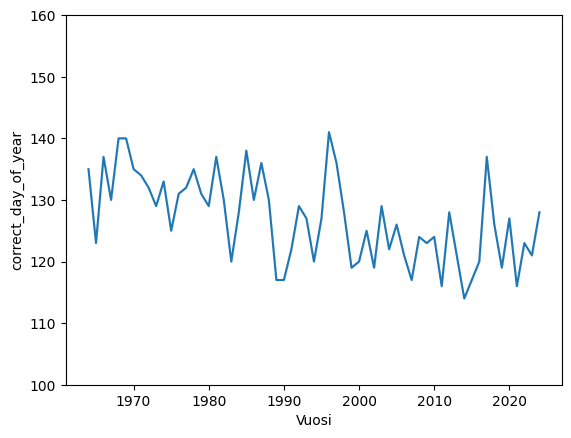

In [5]:
ax = plt.subplot()

sns.lineplot(x=df['Vuosi'], y=df['correct_day_of_year'])

ax.set(ylim=(100,160))


The average detaching day seems to have gone down by more than 10 days, according to the data.

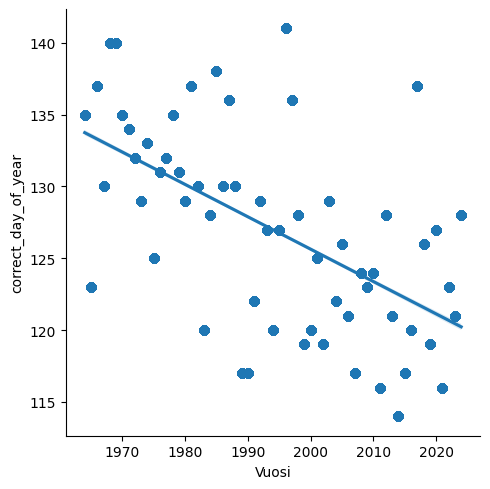

In [6]:
sns.lmplot(data=df, x='Vuosi', y='correct_day_of_year')

Splitting the data to training and testing sets.

In [7]:
features = ['Vuosi', 'Kuukausi', 'Päivä', 'Sademäärä [mm]', 'Lumensyvyys [cm]', 'Ilman keskilämpötila [°C]', 'Maanpintaminimi [°C]', 'Ylin lämpötila [°C]', 'Alin lämpötila [°C]']
label = 'correct_day_of_year'

X, y = df[features].values, df[label].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print(X_test)

[[ 1.974e+03  2.000e+00  1.100e+01 ... -1.050e+01 -7.800e+00 -1.060e+01]
 [ 1.982e+03  3.000e+00  1.400e+01 ... -8.200e+00 -4.400e+00 -8.000e+00]
 [ 1.989e+03  1.100e+01  7.000e+00 ...  1.500e+00  5.400e+00  1.700e+00]
 ...
 [ 2.010e+03  3.000e+00  1.600e+01 ... -3.800e+01 -6.500e+00 -3.520e+01]
 [ 1.992e+03  1.000e+01  2.200e+01 ... -2.680e+01 -1.450e+01 -2.550e+01]
 [ 2.014e+03  3.000e+00  2.400e+01 ...  0.000e+00  2.400e+00 -4.400e+00]]


Linear regression

In [8]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse:.2f}")
print(f"R2 score: {r2:.2f}")

Mean squared error: 32.29
R2 score: 0.33


Decision tree

In [9]:
clf = DecisionTreeClassifier(max_depth=5)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

print()
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

         114       0.00      0.00      0.00        88
         116       0.14      1.00      0.24       162
         117       1.00      0.53      0.69       365
         119       0.00      0.00      0.00       276
         120       0.19      0.72      0.30       354
         121       0.00      0.00      0.00       285
         122       1.00      1.00      1.00       173
         123       1.00      0.33      0.49       287
         124       0.40      1.00      0.57       184
         125       0.00      0.00      0.00       179
         126       1.00      0.51      0.68       170
         127       0.00      0.00      0.00       271
         128       1.00      0.25      0.40       346
         129       0.00      0.00      0.00       382
         130       0.65      1.00      0.79       383
         131       0.39      1.00      0.57       184
         132       0.00      0.00      0.00       188
         133       0.23    

e:\Koulu\3_Vuosi\Data-analytics\data-analytics-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Koulu\3_Vuosi\Data-analytics\data-analytics-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Koulu\3_Vuosi\Data-analytics\data-analytics-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

K-Nearest neighbor

In [10]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

print(y_pred)

Accuracy: 0.39755351681957185
[131 130 117 ... 124 122 114]


Final prediction: 30.4.2025

In [11]:
final_pred = model.predict(df2[features].values)

avg_pred = int(sum(final_pred) / len(final_pred))

date = datetime(2025,1,1) + timedelta(avg_pred - 1)

print(date)

2025-04-30 00:00:00
